In [1]:
import eurostat
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

code_renewables = 'nrg_inf_epcrw'  # Electricity production capacities for renewables and wastes
code_other = 'nrg_inf_epc'    # Electricity production capacities by main fuel groups and operator
code_pop = 'demo_pjangroup'

## Loadnig the data

In [2]:
def load_data(code):
    pars = eurostat.get_pars(code)
    
    descriptions = {}
    for par in pars:
        par_values = eurostat.get_par_values(code, par)
        dic = eurostat.get_dic(code, par)
        tempdict = {}
        for flag, description in dic:
            if(flag in par_values):
                tempdict[flag] = description
        descriptions[par] = tempdict
    
    data = eurostat.get_data(code)
    
    return data, descriptions

In [3]:
data_renewables, descriptions_renewables = load_data(code_renewables)
columns = list(data_renewables[0])
columns[4] = 'geo'
data_renewables = pd.DataFrame(data_renewables[1:], columns=columns)

In [4]:
data_other, descriptions_other = load_data(code_other)
columns = list(data_other[0])
columns[5] = 'geo'
data_other = pd.DataFrame(data_other[1:], columns=columns)

In [5]:
data_pop, descriptions_pop = load_data(code_pop)
columns = list(data_pop[0])
columns[4] = 'geo'
data_pop = pd.DataFrame(data_pop[1:], columns=columns)

In [6]:
countries_in_both= set(np.unique(data_other['geo'])) & set(np.unique(data_renewables['geo']))

In [7]:
COUNTRY = data_renewables['geo'] == None
plant_tec = data_renewables['plant_tec'] == 'CAP_NET_ELC'
for geo in countries_in_both:
    COUNTRY = np.logical_or(COUNTRY, data_renewables['geo'] == geo)

condition_renewables = np.logical_and(COUNTRY, plant_tec)

In [8]:
plant_tec =  data_other['plant_tec'] == 'CAP_NET_ELC'
OPERATOR = data_other['operator'] == 'PRR_MAIN'
in_RENEWABLES = data_other['siec'] == None
for siec in np.unique(data_renewables['siec']):
    in_RENEWABLES = np.logical_or(in_RENEWABLES, data_other['siec'] == siec)
    
COUNTRY = data_other['geo'] == None
for geo in countries_in_both:
    COUNTRY = np.logical_or(COUNTRY, data_other['geo'] == geo)

in_RENEWABLES = np.negative(in_RENEWABLES)

condition_other = np.logical_and(plant_tec, in_RENEWABLES)
condition_other = np.logical_and(condition_other, OPERATOR)
condition_other = np.logical_and(condition_other, COUNTRY)

data_combined = pd.concat(
    [data_other.drop('operator', axis=1).loc[condition_other], data_renewables.loc[condition_renewables]]
    ).sort_values(by=['siec', 'geo']).reset_index().drop(['index','freq','plant_tec','unit'], axis=1)

## Making a lookup function

In [9]:
what_is_descriptions = defaultdict(dict)
def what_is_data(descriptions={}, reset=False):
    if reset:
        global what_is_descriptions
        what_is_descriptions = defaultdict(dict)
        return
    for name in descriptions.keys():
        for tip, description in descriptions[name].items():
            what_is_descriptions[name][tip] = description

In [10]:
what_is_data(reset=True)
what_is_data(descriptions_other)
# what_is_data(descriptions_pop)
what_is_data(descriptions_renewables)
def what_is(descriptor, short=False):
    for name, description in what_is_descriptions.items():
        if descriptor in description:
            return f'type: {name} --> {descriptor}: {what_is_descriptions[name][descriptor]}' if not short else f'{what_is_descriptions[name][descriptor]}'
    return f'{descriptor} does not exsist'

In [11]:
countries_only_in_renewables = set(descriptions_renewables['geo'].keys()) - set(descriptions_other['geo'].keys())
countries_only_in_renewables

{'GE', 'IS', 'MD', 'UA', 'UK', 'XK'}

## Imputing missing data from population

# TODO ugotov kako bujse imputirat

In [12]:
AGE = data_pop['age'] == 'TOTAL'
GENDER = data_pop['sex'] == 'T'
is_COUNTRY = data_pop['geo'] == None

for country in descriptions_renewables['geo'].keys():
    if country != 'EA20' and country != 'EU27_2020':
        is_COUNTRY = np.logical_or(is_COUNTRY, data_pop['geo'] == country)
condition = np.logical_and(AGE, GENDER)
condition = np.logical_and(condition, is_COUNTRY)
data_pop_all = data_pop.loc[condition]


data_pop_all = data_pop_all.drop(['freq','unit','age','sex'], axis=1)

In [13]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
imputer = KNNImputer(n_neighbors=2, weights="distance")
# imputer = IterativeImputer(max_iter=10, random_state=0)
# imputer = SimpleImputer(max_iter=10, random_state=0)
a = imputer.fit_transform(np.rot90(data_pop_all.drop(['geo'], axis=1), k=1))
neki = []
a = np.rot90(a, k=3)
for country, pop in zip(data_pop_all['geo'], a):
    neki.append(pop) 

neki = np.array(neki)
data_pop_imputed = {}

data_pop_imputed['geo'] = data_pop_all['geo']
for name, ind in zip(data_pop_all.columns[1:], range(0, len(data_pop_all.columns)-1)):
    data_pop_imputed[name] = neki[:, ind]
data_pop_imputed = pd.DataFrame(data_pop_imputed)

is_COUNTRY = data_pop_imputed['geo'] == 'XK'

# for country in {'BA', 'FR', 'GE', 'MD', 'ME', 'RS', 'UA', 'XK', 'UK'}:
#     is_COUNTRY = np.logical_or(is_COUNTRY, data_pop_imputed['geo'] == country)

for year in data_pop_imputed.keys()[1:]:
    if year not in data_combined.keys():
        data_pop_imputed = data_pop_imputed.drop(str(year), axis=1)

data_pop_imputed[is_COUNTRY]

,geo,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
2572,XK,2.000322e+06,1.999806e+06,1.999709e+06,1.999587e+06,1.999449e+06,1.999275e+06,1.999039e+06,1.998735e+06,1.998388e+06,...,1.948402e+06,1.783113e+06,1.775939e+06,1771604.0,1783531.0,1798506.0,1795666.0,1782115.0,1798186.0,1773971.0


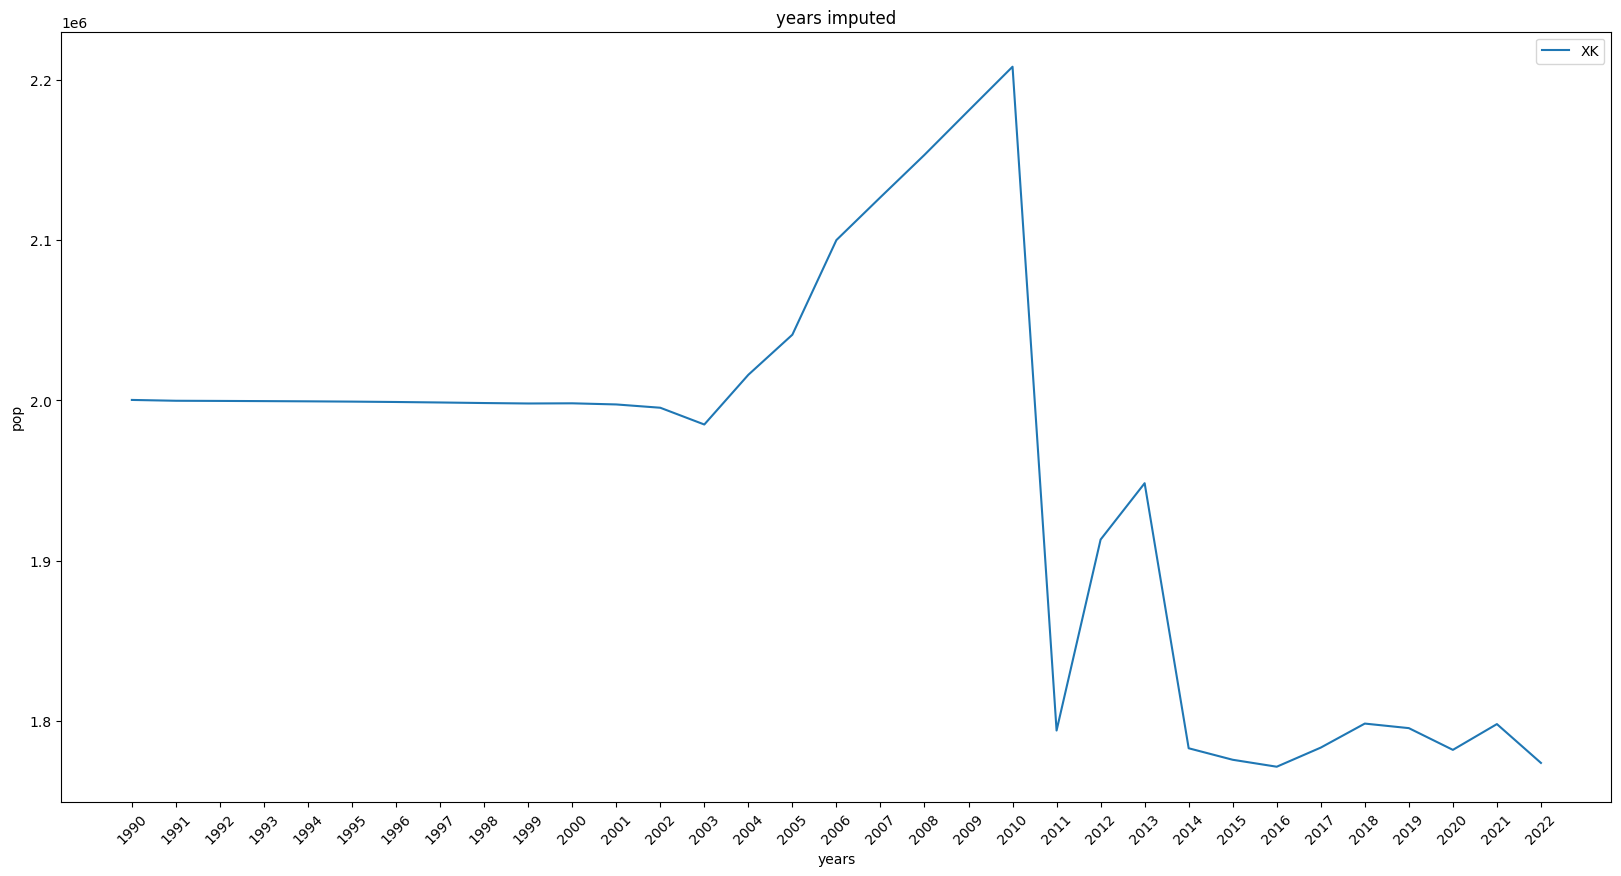

In [14]:
years = data_pop_imputed[is_COUNTRY].columns.tolist()[1:]

# vosta_energij_po_vrsti.plot(x='1990', y='1992')
# fig2 = {'R5100', 'X9900', 'RA500', 'RA200'}
#         CF         N9000      R5100    RA100      RA200    RA300     RA400      RA500    X9900
# colors= ['#232023', '#39FF14', 'green', '#007fff', 'cyan', '#787276', '#a91b0d', 'navy', '#FF00FF']

plt.figure(figsize=(20, 10))
for row in data_pop_imputed[is_COUNTRY].values:
    plt.plot(years, row[1:], label=row[0])

# plt.subplot(1, 2, 1)
plt.ylabel('pop')
plt.xlabel('years')
plt.xticks(rotation=45)
plt.title('years imputed')
plt.legend();

In [15]:
what_is('RA120')

'type: siec --> RA120: Mixed hydro power'

In [16]:
pd.set_option('display.max_columns', 100) #default 20

In [17]:
not_in_energy = []
for geo in data_pop_all['geo']:
    if  what_is(geo)[-6:] == 'exsist':
        not_in_energy.append(geo)

In [18]:
for name in not_in_energy:
    data_pop_all = data_pop_all.drop(data_pop_all[data_pop_all['geo'] == name].index)

In [19]:

import numpy as np
is_PRODUCING = data_other['operator'] == 'PRR_MAIN'
is_SI = data_other['geo'] == 'DE'
is_ACTIVE =  data_other['plant_tec'] == 'CAP_NET_ELC'
condition = np.logical_and(is_PRODUCING, is_ACTIVE)
condition = np.logical_and(condition, is_SI)
data_other.loc[condition].drop([str(year) for year in range(1990, 2021)], axis=1).drop("2022", axis=1)

,freq,siec,plant_tec,operator,unit,geo,2021
44,A,CF,CAP_NET_ELC,PRR_MAIN,MW,DE,88178.0
266,A,N9000,CAP_NET_ELC,PRR_MAIN,MW,DE,8113.0
488,A,RA100,CAP_NET_ELC,PRR_MAIN,MW,DE,10809.0
562,A,RA110,CAP_NET_ELC,PRR_MAIN,MW,DE,4321.0
784,A,RA120,CAP_NET_ELC,PRR_MAIN,MW,DE,1134.0
1006,A,RA130,CAP_NET_ELC,PRR_MAIN,MW,DE,5354.0
1228,A,RA200,CAP_NET_ELC,PRR_MAIN,MW,DE,46.0
1450,A,RA300,CAP_NET_ELC,PRR_MAIN,MW,DE,63711.0
1524,A,RA310,CAP_NET_ELC,PRR_MAIN,MW,DE,0.0
1746,A,RA320,CAP_NET_ELC,PRR_MAIN,MW,DE,0.0


In [20]:
# my_filter_pars = {'geo': ['SI'] , 'siec' : [ 'RA100', 'RA110','RA110ROR', 'RA120', 'RA130']}
# my_filter_pars = {'geo': ['SI'] , 'siec' : [ 'RA100', 'RA110', 'RA120', 'RA130']}
# data = eurostat.get_data(code, filter_pars=my_filter_pars)
# data[1:]

In [21]:


# my_filter_pars = {'geo': ['SI'] , 'siec' : [ 'RA100', 'RA110','RA110ROR', 'RA120', 'RA130']}
# my_filter_pars = {'geo': ['SI'] , 'siec' : [ 'RA100', 'RA110', 'RA120', 'RA130']}
# data = eurostat.get_data(code_renewables, filter_pars=my_filter_pars)

In [22]:
siec_not_to_include = {'RA110','RA120','RA130','RA310','RA320','RA410','RA420','RA420AC',
                       'RA420DC','R5210P','R5220P','R5290','R5300','RA110ROR','RA420KW20-1000',
                       'RA420KW30-1000','RA420KW30-1000_OG','RA420KW30-1000_RT','RA420KW_LT10',
                       'RA420KW_LT20','RA420KW_LT30','RA420KW_LT30_OG','RA420KW_LT30_RT','RA420MW_GT1',
                       'RA420MW_GT1_OG','RA420MW_GT1_RT','RA420OG','W6000','W6100','W6200','TOTAL'}

1. Za vsak tip proizvodnje energije katera država najbolj proizvaja omenjeno energijo

In [23]:
YEAR = '2022' # change te year of the data

In [24]:
SIEC = data_combined['siec'] == None
for siec in siec_not_to_include:
    SIEC = np.logical_or(SIEC, data_combined['siec'] == siec)
SIEC = np.negative(SIEC)
GEO = np.logical_and(data_combined['geo'] != 'EA20', data_combined['geo'] != 'EU27_2020')
condition = np.logical_and(SIEC, GEO)

In [25]:
data_combined_YEAR = data_combined.loc[condition].drop([key for key in data_pop_imputed.keys() if key not in {'geo', YEAR}], axis=1).reset_index().drop('index', axis=1)

In [26]:
data_pop_YEAR = data_pop_imputed.drop([key for key in data_pop_imputed.keys() if key not in {'geo', YEAR}], axis=1)
GEO = data_pop_YEAR['geo'] == None
for country in np.unique(data_combined_YEAR['geo']):
    GEO = np.logical_or(GEO, data_pop_YEAR['geo'] == country)
data_pop_YEAR = data_pop_YEAR.loc[GEO].reset_index().drop('index', axis=1)

In [27]:
data_pop_YEAR_reshaped = pd.DataFrame(data_pop_YEAR[YEAR].to_numpy().reshape(1, 35))
data_pop_YEAR_temp = data_pop_YEAR_reshaped.reindex([YEAR], columns=np.unique(data_pop_YEAR['geo']))

In [28]:
for country, val in zip(data_pop_YEAR_temp.keys(), data_pop_YEAR_reshaped.keys()):
    data_pop_YEAR_temp[country] = list(data_pop_YEAR_reshaped[val])
data_pop_YEAR_reshaped = data_pop_YEAR_temp

In [29]:
data_combined_YEAR_reshaped = pd.DataFrame(data_combined_YEAR[YEAR].to_numpy().reshape(9, 35))
data_combined_YEAR_temp = data_combined_YEAR_reshaped.reindex(labels=np.unique(data_combined_YEAR['siec']), columns=np.unique(data_combined_YEAR['geo']))

In [30]:
for country, val in zip(data_combined_YEAR_temp.keys(), data_combined_YEAR_reshaped.keys()):
    data_combined_YEAR_temp[country] = list(data_combined_YEAR_reshaped[val])
data_combined_YEAR_reshaped = data_combined_YEAR_temp
for country in data_combined_YEAR_reshaped.keys():
    data = data_combined_YEAR_reshaped[country].values * 24 * 1000 / data_pop_YEAR_reshaped[country][0]
    data_combined_YEAR_reshaped[country] = data

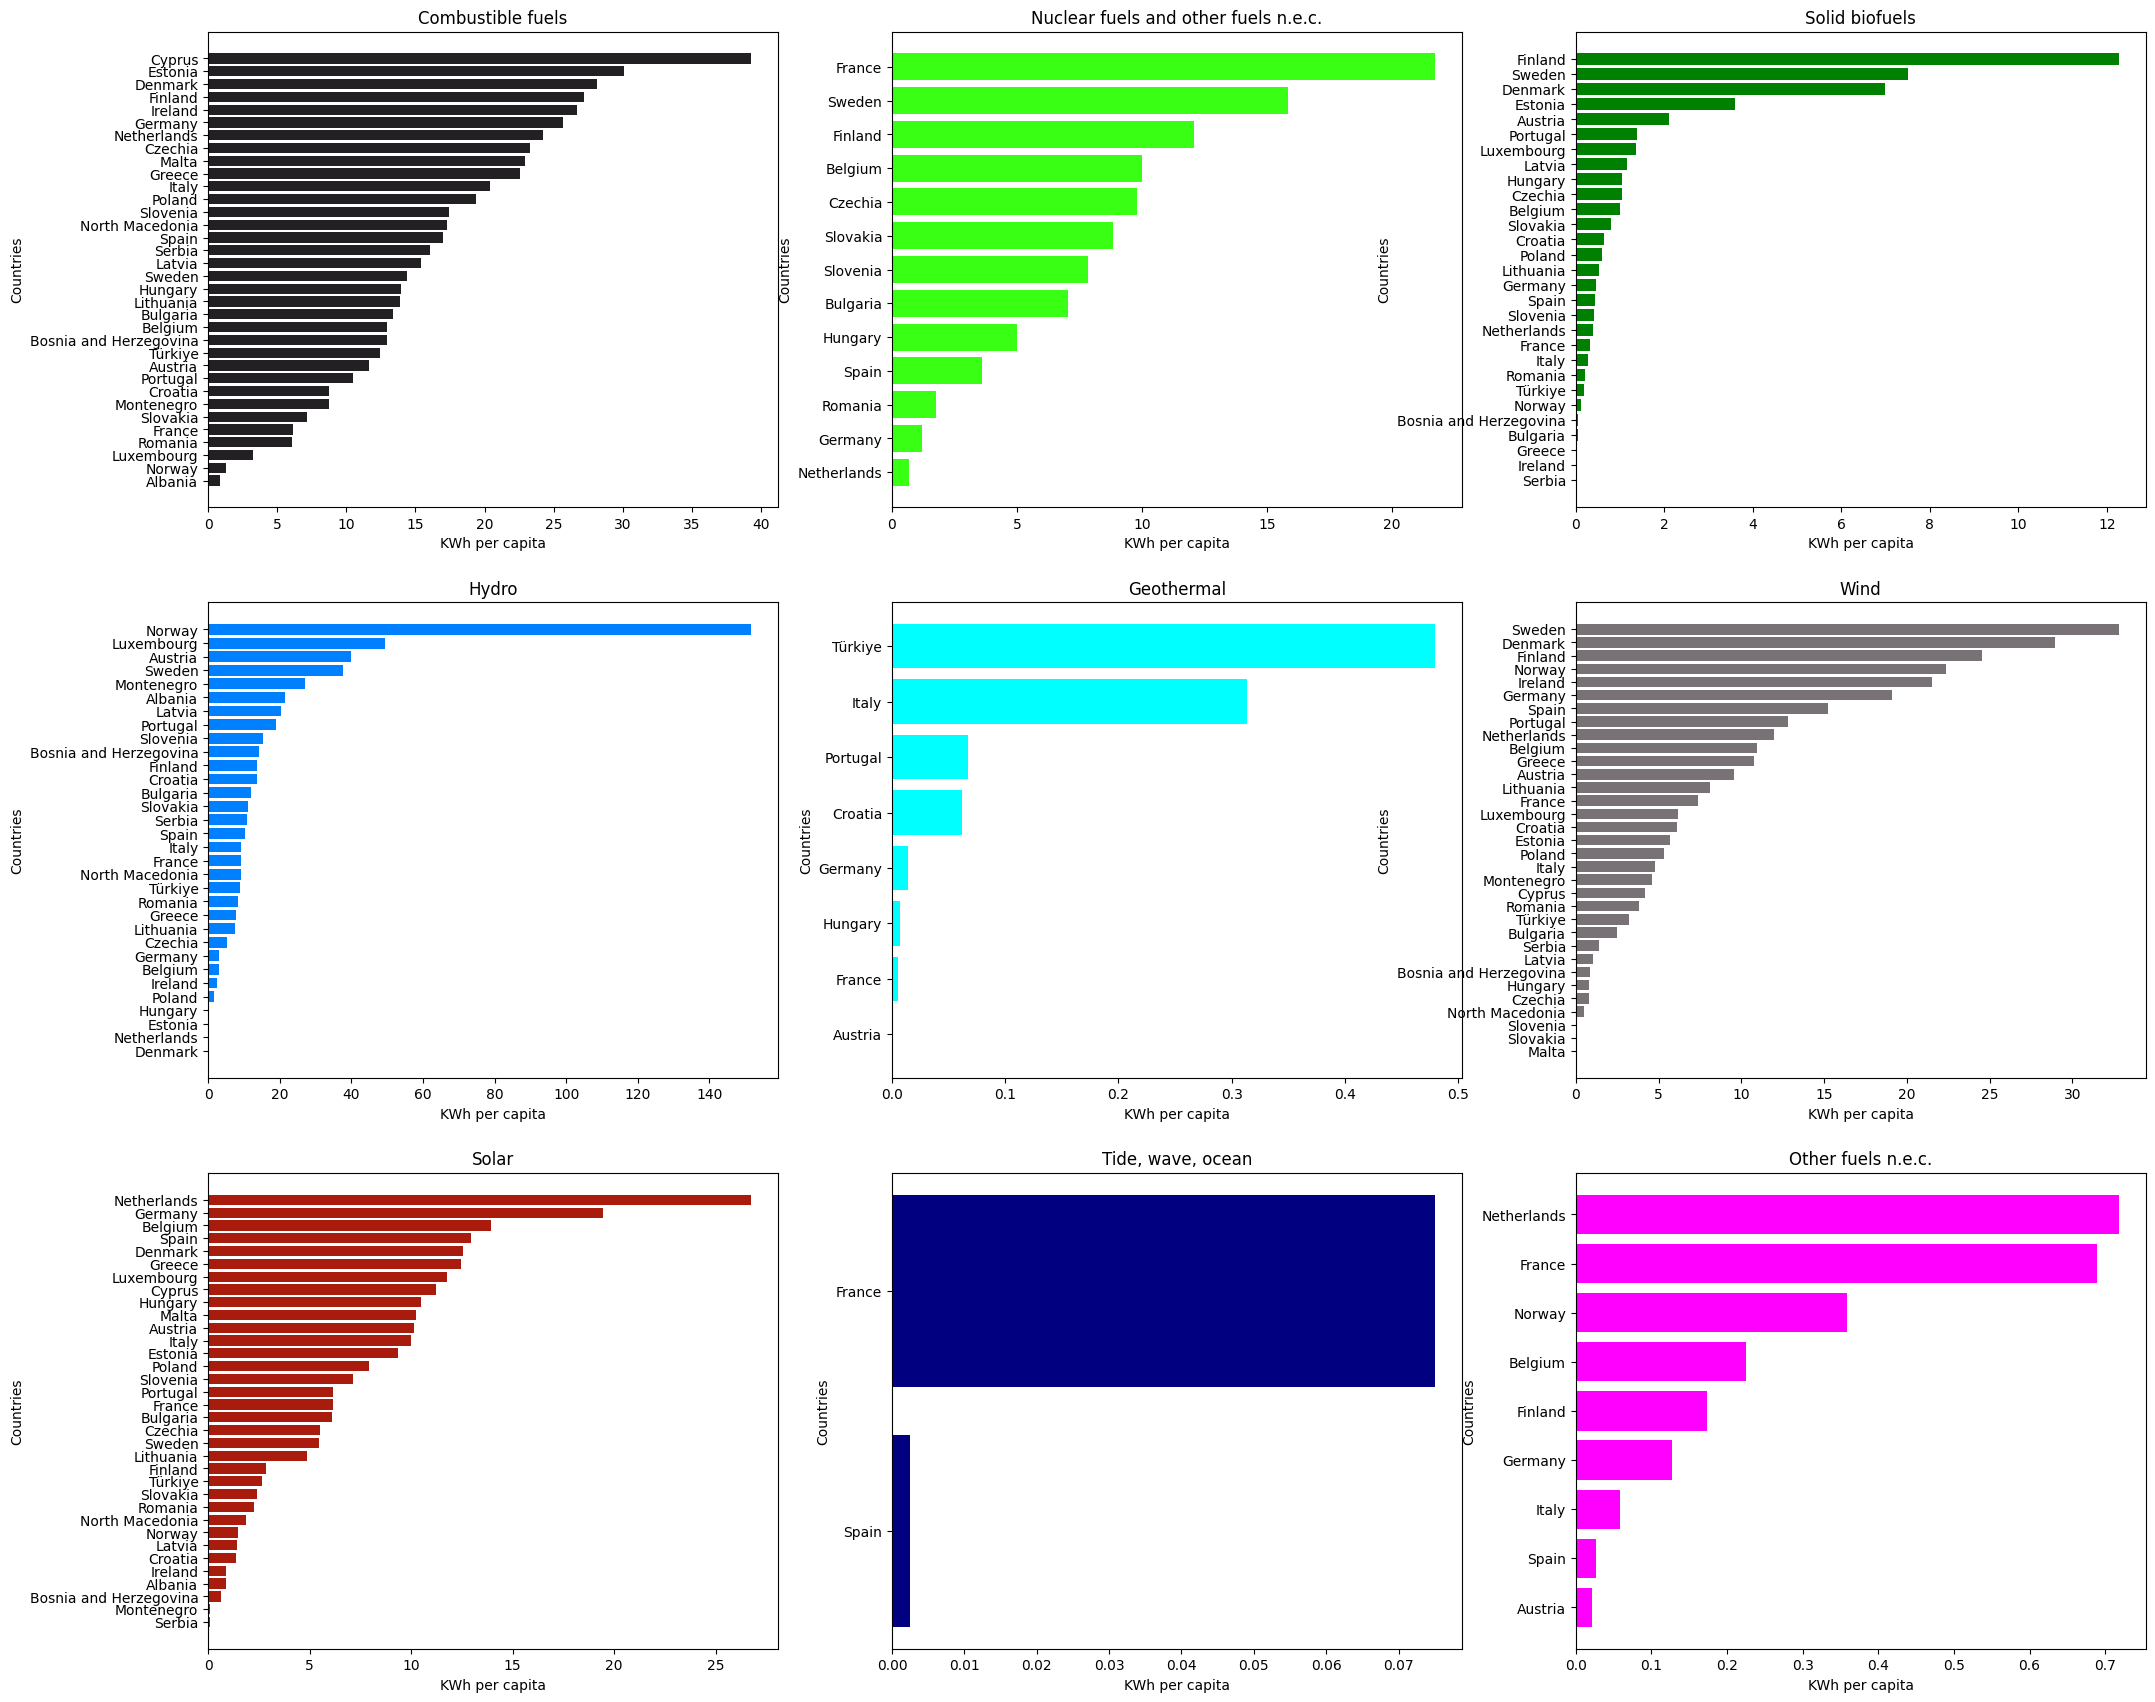

In [31]:
#         CF         N9000      R5100    RA100      RA200    RA300     RA400      RA500    X9900
colors= ['#232023', '#39FF14', 'green', '#007fff', 'cyan', '#787276', '#a91b0d', 'navy', '#FF00FF']

plt.figure(figsize=(25, 21))

for energy_type, color, i in zip(data_combined_YEAR_reshaped.index, colors, range(len(data_combined_YEAR_reshaped.index))):
    row_data = data_combined_YEAR_reshaped.loc[energy_type]
    row_data = row_data.sort_values(axis=0, ascending=True)
    row_data = row_data.loc[row_data > 0]
    plt.subplot(3, 3, i+1)
    plt.barh([what_is(c, short=True)for c in row_data.index], row_data.values, color=color)
    # plt.barh(row_data.index, row_data.values, color=color)
    # print(row_data.tail(10))
    plt.title(what_is(energy_type, short=True))
    plt.ylabel("Countries")
    plt.xlabel("KWh per capita")
plt.show()


2. Kulk je slovenija v zaostanku glede renewable energije (kdaj so ostale države začele s proizvodnjo vs slovenija)

In [32]:
comparison_countries = {'NO', 'DE', 'FR', 'SI', 'BE', 'DK', 'NL', 'ES', 'CZ', 'AL'}

In [33]:
SIEC = data_renewables['siec'] == None
for siec in siec_not_to_include:
    SIEC = np.logical_or(SIEC, data_renewables['siec'] == siec)
SIEC = np.negative(SIEC)
GEO = data_renewables['geo'] == None
for geo in comparison_countries:
    GEO = np.logical_or(GEO, data_renewables['geo'] == geo)
# GEO = np.logical_and(data_renewables['geo'] != 'EA20', data_renewables['geo'] != 'EU27_2020')
condition = np.logical_and(SIEC, GEO)
data_renewables_small = data_renewables.loc[condition].reset_index().drop('index', axis=1).drop(['plant_tec', 'freq', 'unit'], axis=1).set_index('geo')

In [34]:
# len(data_renewables_small)

In [35]:
GEO = data_pop_imputed['geo'] == None
for geo in comparison_countries:
    GEO = np.logical_or(GEO, data_pop_imputed['geo'] == geo)
data_pop_compare = data_pop_imputed.loc[GEO].set_index('geo')
# data_pop_compare

In [36]:
rearange_columns = data_renewables_small.keys().to_list()
rearange_columns.pop(0)
rearange_columns.append('siec')
data_renewables_small = data_renewables_small[rearange_columns]

In [37]:
list_of_siec=[]
for row in range(len(data_renewables_small)):
    siec = data_renewables_small.iloc[row]['siec']
    data_renewables_small.iloc[row] = data_renewables_small.iloc[row] * 24 * 1000 / data_pop_compare.iloc[row % len(data_pop_compare)]
    list_of_siec.append(siec)

data_renewables_small.siec = list_of_siec

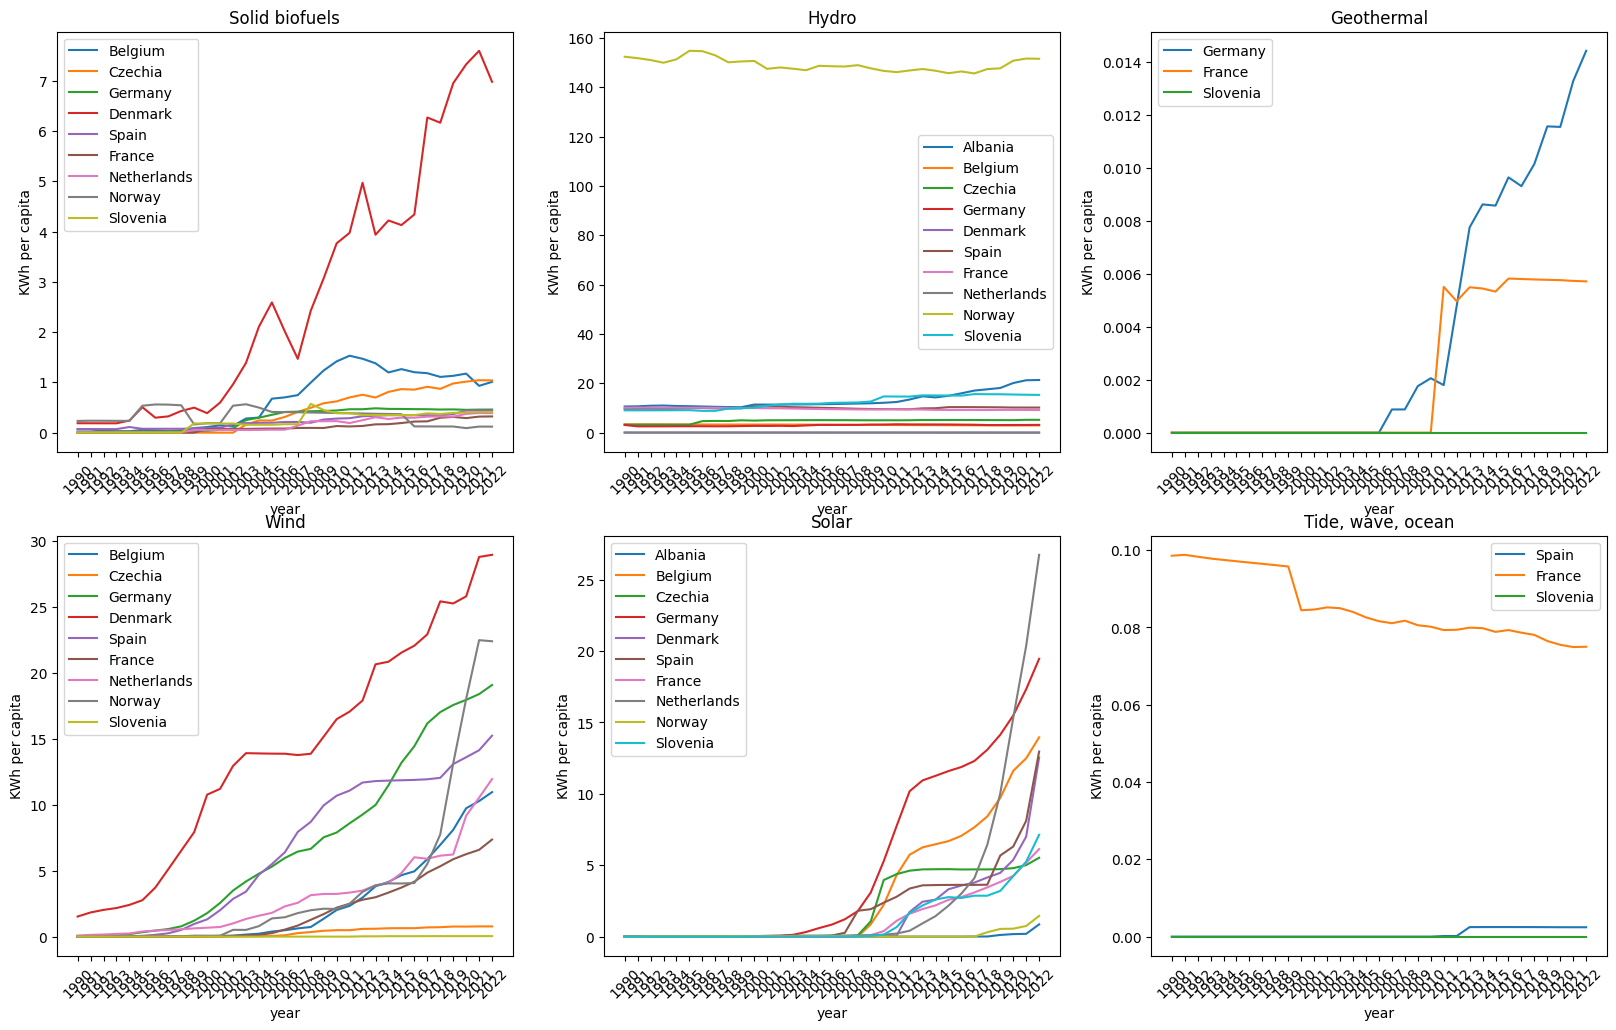

In [38]:
plt.figure(figsize=(20, 12))
for siec, i in zip(np.unique(data_renewables_small.siec), range(len(np.unique(data_renewables_small.siec)))):
    # print(siec)
    data = data_renewables_small.loc[data_renewables_small.siec == siec].drop('siec', axis=1)
    plt.subplot(2, 3, i+1)
    for power, country in zip(data.values, data.index):
        if np.sum(power) == 0 and country != 'SI':
            continue
        plt.plot(data.keys(), power, label=what_is(country, short=True))
        plt.title(what_is(siec, short=True))
        plt.xlabel("year")
        plt.ylabel("KWh per capita")
        plt.legend()
        plt.xticks(rotation=45)
plt.show()

3. Keri tip energije proizvaja največ elektrike v evropi

In [39]:
####   filtriranje data setov

# # is_PRODUCING = data_renewables['operator'] == 'PRR_MAIN'
# # is_TOTAL = data_renewables['siec'] != 'TOTAL'
# is_ACTIVE = data_renewables['plant_tec'] == 'CAP_NET_ELC'
# is_GEO = np.logical_and(data_renewables['geo'] != 'EA20', data_renewables['geo'] != 'EU27_2020')
# for country in countries_only_in_renewables:
#     is_GEO = np.logical_and(is_GEO, data_renewables['geo'] != country)
# condition = np.logical_and(is_GEO, is_ACTIVE)
# # condition = np.logical_and(condition, is_TOTAL)
# # condition = np.logical_and(condition, is_GEO)
# condition_2 = condition
# # data_renewables.loc[condition]

# is_PRODUCING = data_other['operator'] == 'PRR_MAIN'
# # is_TOTAL = data_other['siec'] != 'TOTAL'
# is_ACTIVE =  data_other['plant_tec'] == 'CAP_NET_ELC'
# is_GEO = np.logical_and(data_other['geo'] != 'EA20', data_other['geo'] != 'EU27_2020')
# condition = np.logical_and(is_PRODUCING, is_ACTIVE)
# # condition = np.logical_and(condition, is_TOTAL)
# condition = np.logical_and(condition, is_GEO)
# condition_1 = condition
# # data_other.loc[condition]

condition_combined = np.logical_and(data_combined['geo'] != 'EA20', data_combined['geo'] != 'EU27_2020')

In [40]:
####  ustvarjanje zdruzenega dataseta

dictNeki = {}
dictNeki['siec'] = []
for year in data_combined.keys()[2:]:
    dictNeki[year] = []

for siec in np.unique(data_combined['siec']):
    if siec in siec_not_to_include:
        continue
    dictNeki['siec'].append(siec)
    con = np.logical_and(data_combined['siec'] == siec, condition_combined)
    for year in data_combined.keys()[2:]:
        dictNeki[year].append(np.sum(data_combined.loc[con][year])) 
    
# for siec in np.unique(data_renewables['siec']):
#     if siec in siec_not_to_include:
#         continue
#     dictNeki['siec'].append(siec)
#     con = np.logical_and(data_renewables['siec'] == siec, condition_2)
#     for year in range(1990, 2023):
#         dictNeki[str(year)].append(np.sum(data_renewables.loc[con][str(year)]))


# for siec in np.unique(data_other['siec']):
#     if siec in siec_not_to_include or siec in dictNeki['siec']:
#         continue
#     dictNeki['siec'].append(siec)
#     con = np.logical_and(data_other['siec'] == siec, condition_1)
#     for year in range(1990, 2023):
#         dictNeki[str(year)].append(np.sum(data_other.loc[con][str(year)]))
    
vsota_energij_po_vrsti = pd.DataFrame(dictNeki)

In [41]:
vsota_energij_po_vrsti = vsota_energij_po_vrsti.sort_values('siec')
# vsota_energij_po_vrsti

In [42]:
np.sum(vsota_energij_po_vrsti['2022'])/1000/1000

1.1636275090000001

In [43]:
np.sum(vsota_energij_po_vrsti['2022'])/1000/1000

1.1636275090000001

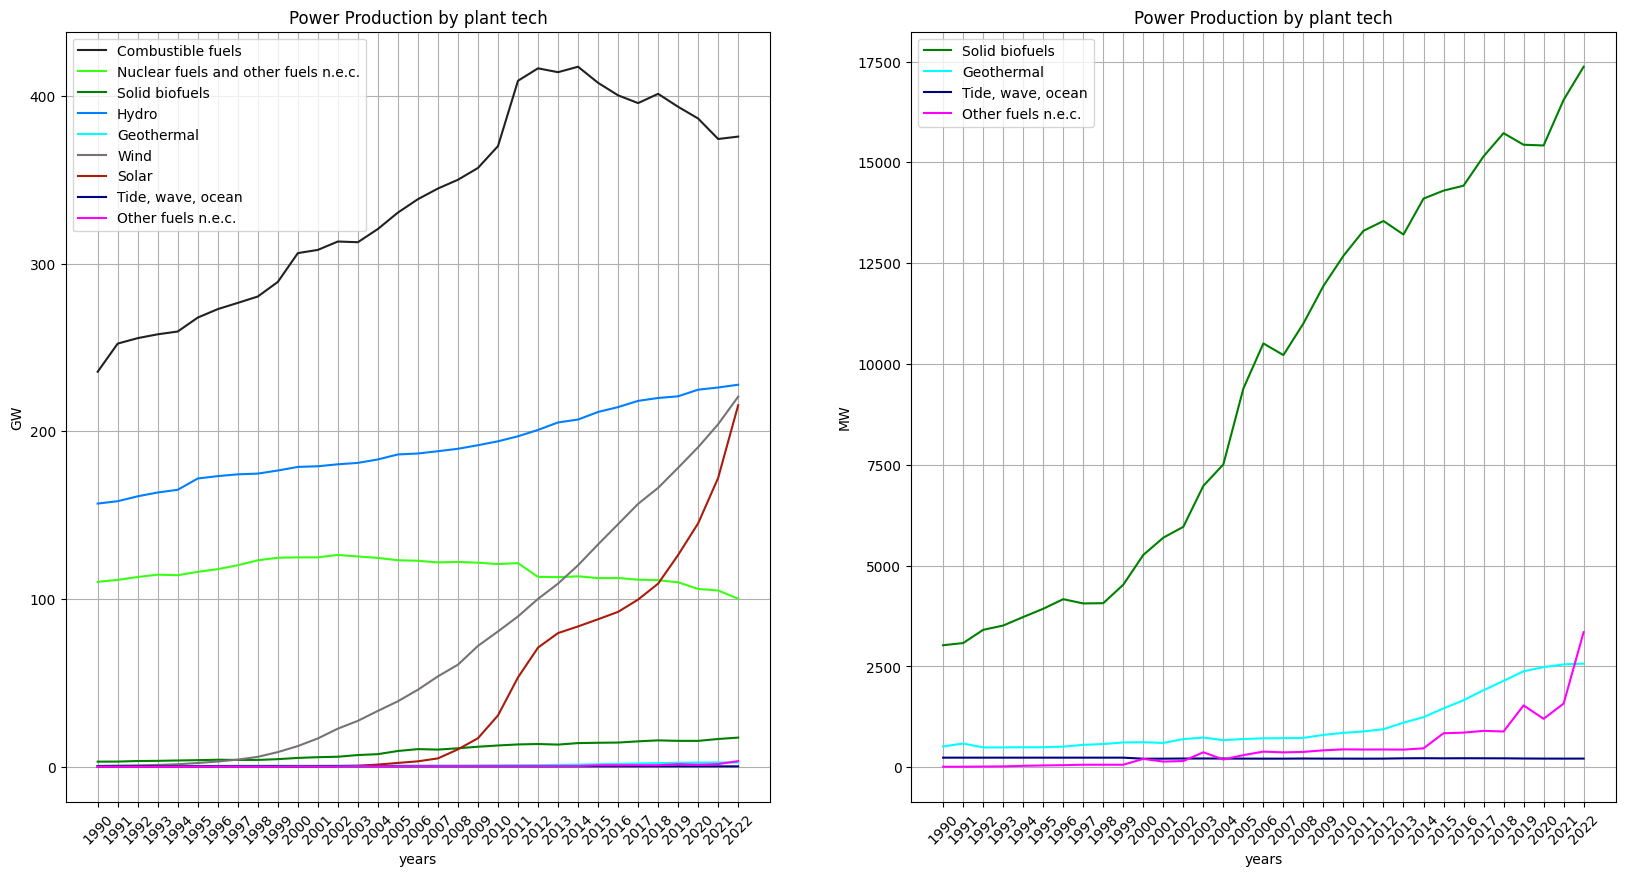

In [44]:
years = vsota_energij_po_vrsti.columns.tolist()[1:]

# vsota_energij_po_vrsti.plot(x='1990', y='1992')
fig2 = {'R5100', 'X9900', 'RA500', 'RA200'}

plt.figure(figsize=(20, 10))
for row, colour in zip(vsota_energij_po_vrsti.values, colors):
    if row[0] in fig2:
        plt.subplot(1, 2, 2)
        plt.plot(years, row[1:], label=what_is(row[0], short=True), color=colour)
    plt.subplot(1, 2, 1)
    plt.plot(years, [power / 1000 for power in row[1:]], label=what_is(row[0], short=True), color=colour)

plt.subplot(1, 2, 1)
plt.ylabel('GW')
plt.xlabel('years')
plt.xticks(rotation=45)
plt.title('Power Production by plant tech')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.ylabel('MW')
plt.xlabel('years')
plt.xticks(rotation=45)
plt.title('Power Production by plant tech')
plt.grid(True)
plt.legend()

plt.show()


In [45]:
data_power_production_normalized = pd.DataFrame({'CF':[], 'N9000':[], 'R5100':[], 'RA100':[], 'RA200':[], 'RA300':[], 'RA400':[], 'RA500':[], 'X9900':[], 'geo':[]})
list_of_geo=[]
for country in data_combined_YEAR_reshaped.keys():
    data_power_production_normalized.loc[len(data_power_production_normalized.index)] = data_combined_YEAR_reshaped[country]
    list_of_geo.append(country)
data_power_production_normalized.geo = list_of_geo
data_power_production_normalized = data_power_production_normalized.set_index('geo')

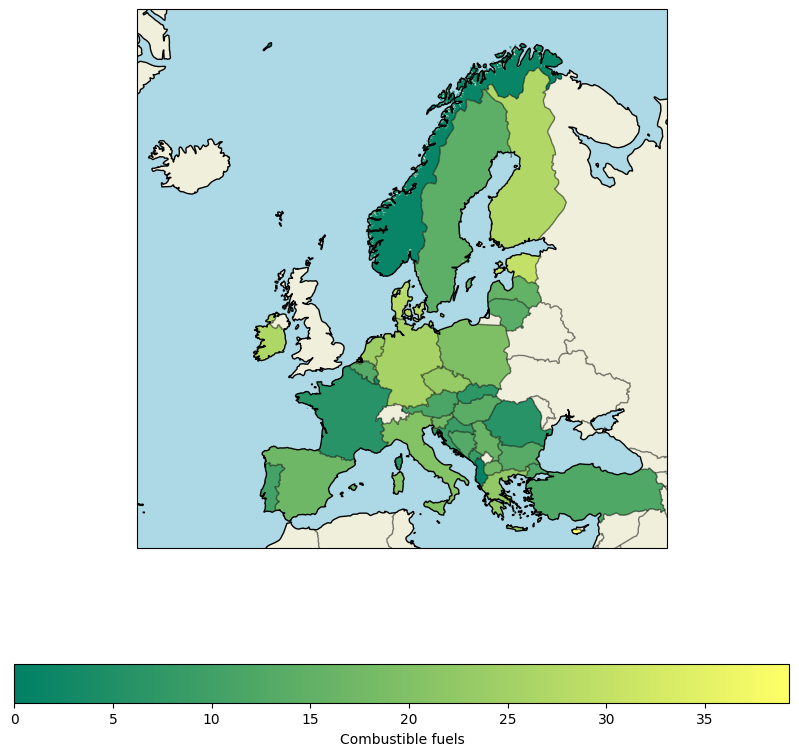

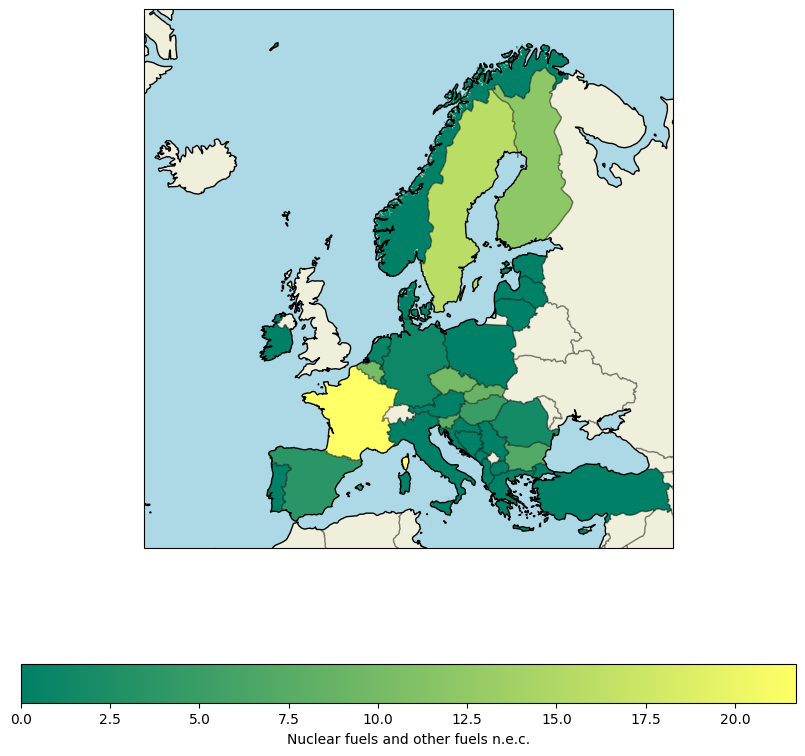

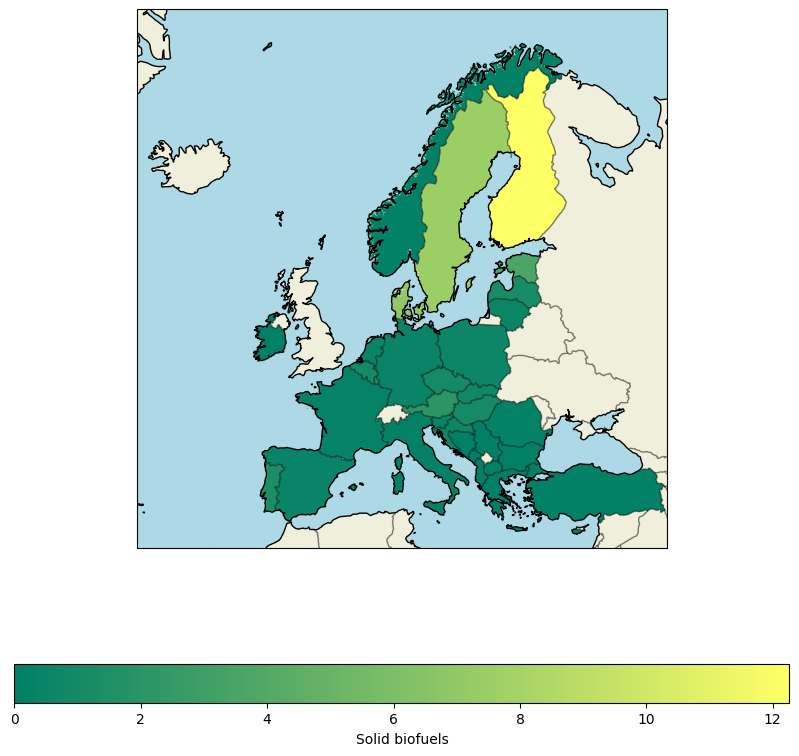

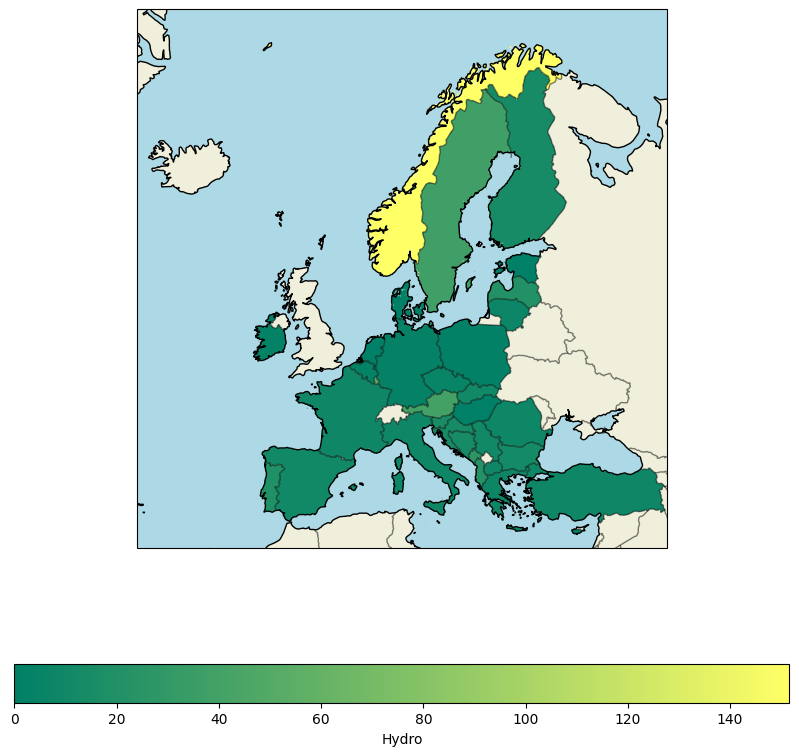

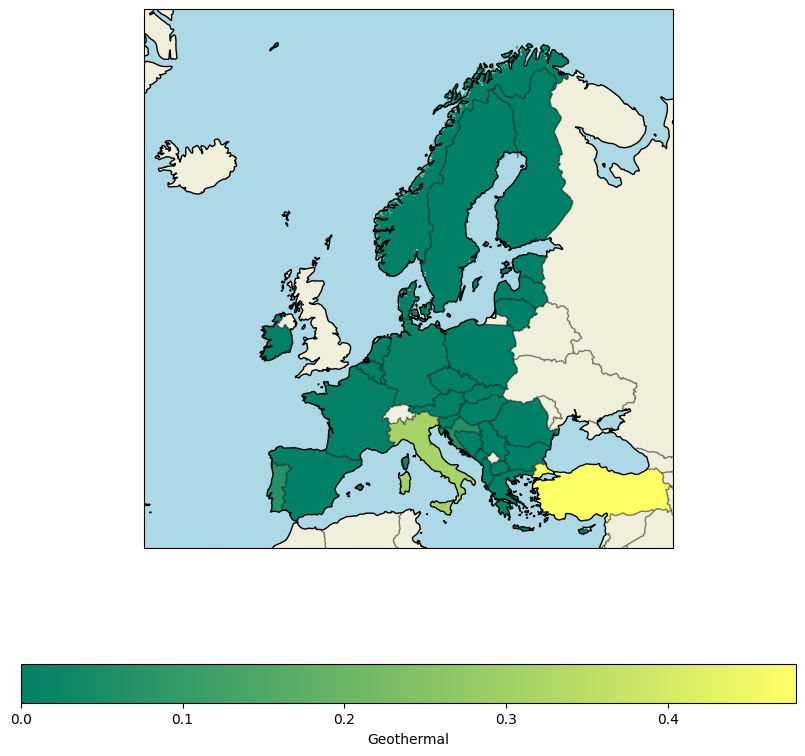

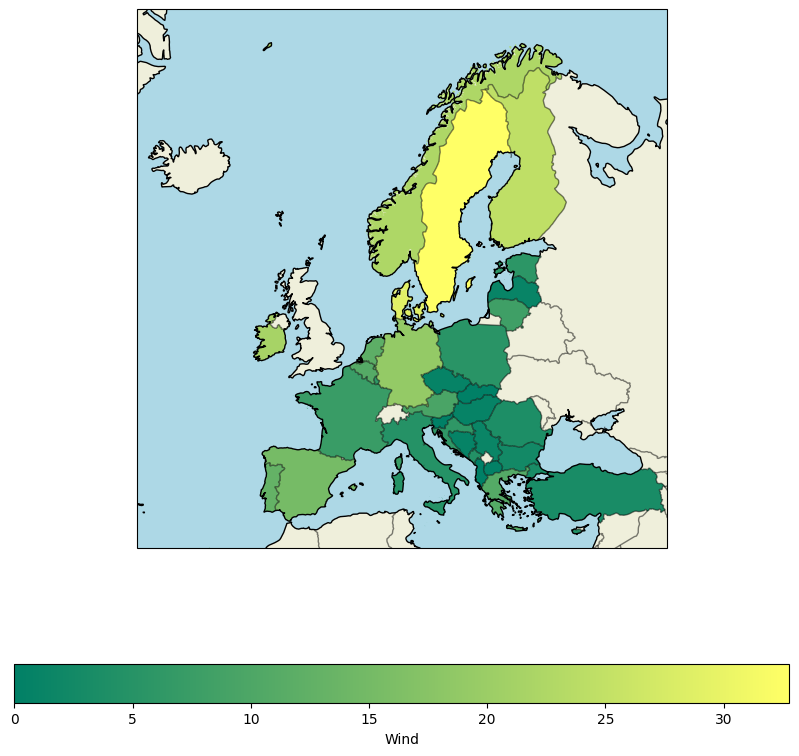

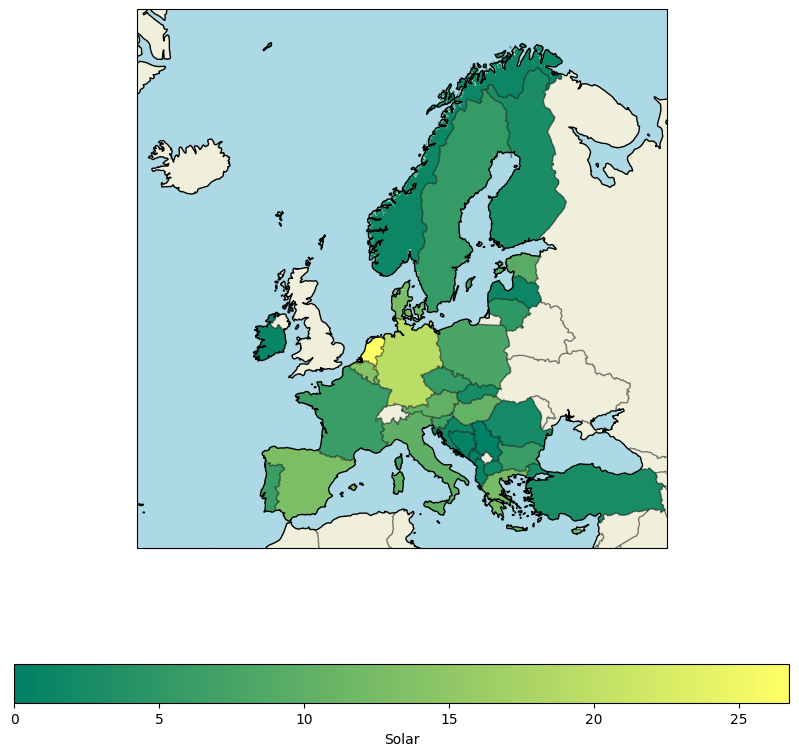

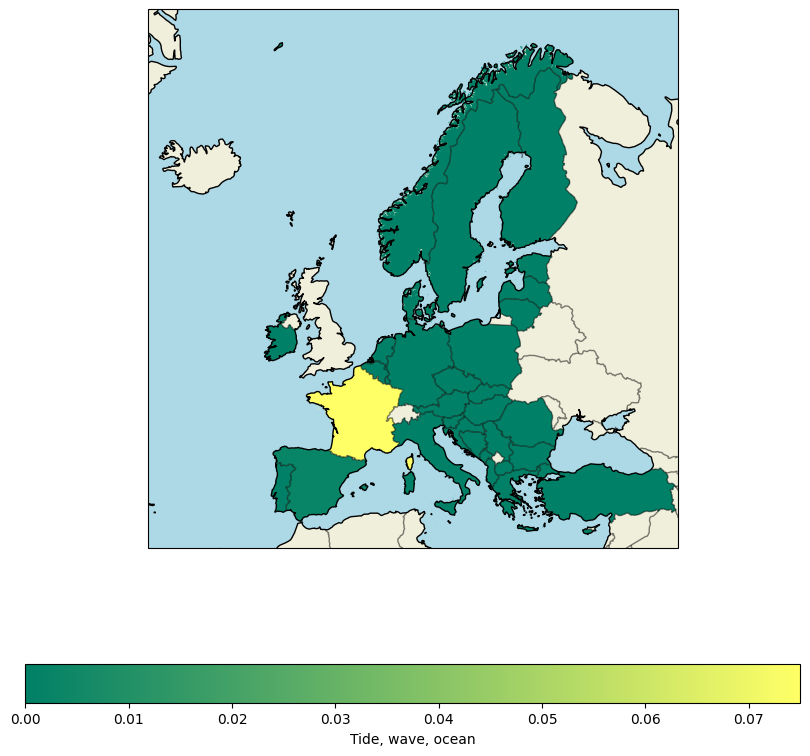

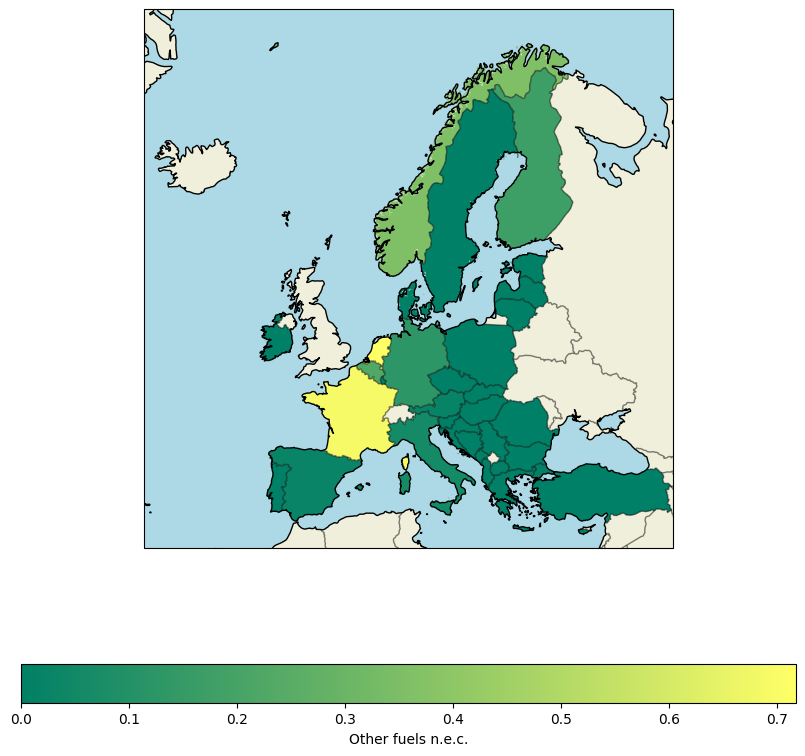

In [46]:
import matplotlib.pyplot as plt
import matplotlib
import cartopy
from cartopy.io import shapereader
import cartopy.crs as ccrs
import geopandas

# get natural earth data (http://www.naturalearthdata.com/)

# get country borders
resolution = '10m'
category = 'cultural'
name = 'admin_0_countries'
shpfilename = shapereader.natural_earth(resolution, category, name)

# read the shapefile using geopandas
df = geopandas.read_file(shpfilename)

# Insert your lists of countries and lag times here
countries=[]
for country in data_power_production_normalized.index:
    # print(country, what_is(country, short=True))
    if country == 'RS':
        countries.append('Republic of Serbia')
        continue
    if country == 'TR':
        countries.append('Turkey')
        continue
    if country == 'XK':
        countries.append('Kosovo')
        continue
    countries.append(what_is(country, short=True))

# Set up the canvas
for siec, i in zip(data_power_production_normalized.keys(), range(len(data_power_production_normalized.keys()))):
    fig = plt.figure(figsize=(10, 10))
    # plt.subplot(3, 3, i+1)
    extent = [-26, 45, 33, 69] # long_min, long_max, lat_min, lat_max
    ax = plt.axes(projection=cartopy.crs.Mercator())
    ax.set_extent(extent)
    # ax.gridlines()

    # Add natural earth features and borders
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
    ax.add_feature(cartopy.feature.OCEAN, facecolor=("lightblue"))
    ax.add_feature(cartopy.feature.LAND)
    ax.coastlines(resolution='50m')

    power = data_power_production_normalized[siec]

    # Normalise the lag times to between 0 and 1 to extract the colour
    power_norm = (power-np.nanmin(power))/(np.nanmax(power) - np.nanmin(power))

    # Choose your colourmap here
    cmap = matplotlib.colormaps['summer'] # https://matplotlib.org/stable/users/explain/colors/colormaps.html


    for country, pow_norm in zip(countries, power_norm):
        # read the borders of the country in this loop
        # print(country)
        poly = df.loc[df['ADMIN'] == country]['geometry'].values[0]
        # get the color for this country
        rgba = cmap(pow_norm)
        # plot the country on a map
        ax.add_geometries(poly, crs=ccrs.PlateCarree(), facecolor=rgba, edgecolor='none', zorder=1);

    # Add a scatter plot of the original data so the colorbar has the correct numbers. Hacky but it works
    dummy_scat = ax.scatter(power, power, c=power, cmap=cmap, zorder=0)
    fig.colorbar(mappable=dummy_scat, label=what_is(siec, short=True), orientation='horizontal');

4. Norveška in hidro, kaj se dogaja?

In [47]:
what_is('RA130')

'type: siec --> RA130: Pumped hydro power'

In [48]:
# data_renewables_small.iloc[row]
data_pop_Norwey = data_pop_imputed.loc[data_pop_imputed['geo'] == 'NO'].set_index('geo')
data_pop_Norwey

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
geo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NO,4233116.0,4249830.0,4273634.0,4299167.0,4324815.0,4348410.0,4369957.0,4392714.0,4417599.0,4445329.0,4478497.0,4503436.0,4524066.0,4552252.0,4577457.0,4606363.0,4640219.0,4681134.0,4737171.0,4799252.0,4858199.0,4920305.0,4985870.0,5051275.0,5109056.0,5165802.0,5213985.0,5258317.0,5295619.0,5328212.0,5367580.0,5391369.0,5425270.0


In [49]:
NO = data_renewables['geo'] == 'NO'

SIEC = data_renewables['siec'] == None
hydro = {'RA110', 'RA110ROR', 'RA120', 'RA130'} # 'RA100',

for siec in hydro:
    SIEC = np.logical_or(SIEC, data_renewables['siec'] == siec)

condition = np.logical_and(NO, SIEC)

data_hydro_Norway = data_renewables.loc[condition].drop(['freq', 'plant_tec', 'unit', 'geo'], axis=1).set_index('siec')
data_hydro_Norway

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
siec,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
RA110,25817.0,25822.0,25838.0,25801.0,26215.0,27379.0,27494.0,27327.0,26978.0,27215.0,26766.0,26319.0,26604.0,26947.0,26721.0,27222.0,27398.0,27647.0,28062.0,28188.0,28367.0,28618.0,29158.0,29682.0,29889.0,29939.0,30281.0,30382.0,31120.0,31387.0,32285.3,32628.3,32822.3
RA110ROR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RA120,1067.0,1067.0,1067.0,1067.0,1067.0,673.0,672.0,672.0,663.0,663.0,1360.0,1360.0,1309.0,1042.0,1309.0,1327.0,1327.0,1310.0,1351.0,1351.0,1326.0,1351.0,1351.0,1351.0,1351.0,1433.0,1536.0,1530.0,1410.0,1410.0,1446.7,1446.7,1446.7
RA130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
for row in range(len(data_hydro_Norway)):
    data_hydro_Norway.iloc[row] = data_hydro_Norway.iloc[row] * 24 * 1000 / data_pop_Norwey.iloc[0]
data_hydro_Norway

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
siec,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
RA110,146.371609,145.824186,145.101803,144.033484,145.476743,151.111786,150.998282,149.303597,146.566495,146.931757,143.437408,140.260903,141.133220,142.067706,140.100497,141.831636,141.707105,141.745141,142.170929,140.961967,140.135882,139.591346,140.355043,141.027364,140.404803,139.094762,139.383600,138.669464,141.037337,141.377258,144.356898,145.246819,145.197419
RA110ROR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RA120,6.049444,6.025653,5.992090,5.956503,5.921178,3.714461,3.690654,3.671534,3.601957,3.579488,7.288159,7.247799,6.944196,5.493545,6.863199,6.913915,6.863469,6.716321,6.844591,6.756053,6.550576,6.589835,6.503178,6.418973,6.346378,6.657630,7.070216,6.983223,6.390188,6.351099,6.468613,6.440071,6.399829
RA130,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


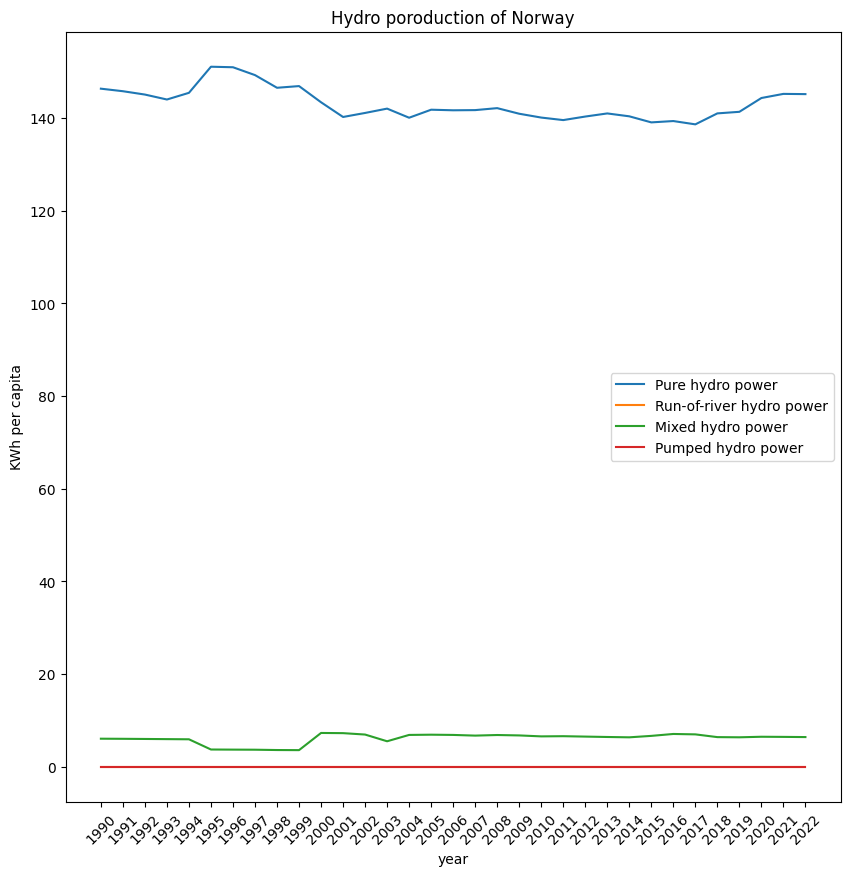

In [51]:
plt.figure(figsize=(10, 10))
plt.title("Hydro poroduction of Norway")

for power, siec in zip(data_hydro_Norway.values, data_hydro_Norway.index):
    plt.plot(data_hydro_Norway.keys(), power, label=what_is(siec, short=True))
    plt.xlabel("year")
    plt.ylabel("KWh per capita")
    plt.legend()
    plt.xticks(rotation=45)
plt.show()